In [624]:
# Program To Read video 
# and Extract Frames 

# import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install moviepy

import cv2 
import os
import sys
import shutil
import numpy as np
import moviepy.video.io.ImageSequenceClip
import torch 
import numpy as np
from PIL import Image
from torch import optim, nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms
from sklearn.metrics import mean_squared_error
from copy import copy
from scipy.spatial.distance import euclidean

In [296]:
def FrameCapture(path, vid_num): 
      
    # Path to video file 
    vidObj = cv2.VideoCapture(path) 
  
    # Used as counter variable 
    count = 0
    success = 1
    images=[]
    try:
        shutil.rmtree("lebron_dunk" + str(vid_num))
        os.mkdir("lebron_dunk" + str(vid_num))
    except OSError as e:
        os.mkdir("lebron_dunk" + str(vid_num))
    while success: 
  
        # vidObj object calls read 
        # function extract frames 
        success, image = vidObj.read() 
        # Saves the frames with frame-count 
        if image is not None and len(image) > 0:
            cv2.imwrite("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg", image) 
            img = Image.open("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = img.resize((img.size[0]//10, img.size[1]//10), Image.ANTIALIAS)
            img.save("lebron_dunk" + str(vid_num) + "/frame" + str(1000+count) + ".jpg")
            img = ToTensor()(img) # unsqueeze to add artificial first dimension
            images.append(img)
        count += 1
#     return np.array(images).astype(np.float32)
    return images

In [222]:
data = []
for i in range(1, 11):
    temp = FrameCapture("movies/lebron_dunk" + str(i) + ".mp4", i)
    data.append(temp)

In [356]:
def create_img_folder(images, folder_name):
    try:
        shutil.rmtree(folder_name)
        os.mkdir(folder_name)
    except OSError as e:
        os.mkdir(folder_name)
    count=0
    for image in images:
        im = transforms.ToPILImage()(image).convert("RGB")
        im.save(folder_name + "/frame" + str(1000+count) + ".jpg")
        count+=1

In [4]:
def recreate_movie(image_folder, new_name):
    fps=30
    image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    image_files.sort()
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
    clip.write_videofile(new_name + '.mp4')

In [5]:
def display_tensor_image(result):
    im = transforms.ToPILImage()(result).convert("RGB")
    display(im)

In [352]:
def grade_results(y_true, y_pred):
    errors=[]
    for i in range(len(y_true)):
        y_pred_temp = y_pred[i].detach().numpy()
        error = mean_squared_error(y_true[i].reshape(-1), y_pred_temp.reshape(-1))
        print(str(i)+": " + str(error))
        errors.append(error)
    errors = np.array(errors)
    print("avg error: " + str(errors.mean()))
    return errors

In [685]:
def get_mean_variance(data):
    data = np.array(data)
    mean = data.mean()
    variances=[]
    for d in data:
        variances.append((d-mean)**2)
    return mean, np.array(variances)

In [716]:
def get_latent_dist(latent_vars):
    dist = []
    for i in range(0,len(latent_vars)-1):
        dist.append(euclidean(latent_vars[i], latent_vars[i+1]))
    return np.array(dist)

In [644]:
recreate_movie('lebron_dunk1', 'recreated_movies/lebron_1')

t:   0%|          | 0/119 [00:00<?, ?it/s, now=None]

Moviepy - Building video recreated_movies/lebron_1.mp4.
Moviepy - Writing video recreated_movies/lebron_1.mp4



Moviepy - Done !
Moviepy - video ready recreated_movies/lebron_1.mp4


In [38]:
len(data[0])

119

In [13]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
latent_dim = 20
transformations = transforms.ToTensor()
# mnist_train =  datasets.MNIST(loc_data, train=True, download=True, transform = transformations)
# mnist_test = datasets.MNIST(loc_data, train=False, download=True, transform = transformations)

In [49]:
images = data[0]
batch_size = 5
x_len = images[0].shape[0]
y_len = images[0].shape[1]
z_len = images[0].shape[2]
total_len = images[0].shape[0]*images[0].shape[1]*images[0].shape[2]

In [50]:
from torch.utils.data import DataLoader
train_loader = DataLoader(images,batch_size=batch_size,drop_last = True,shuffle=True)

In [100]:

class Encoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(-1, x_len, y_len, z_len)

In [298]:
from torch import exp, randn_like
def sample(mu, logvar, testing=False):
  ## YOUR CODE HERE ##
    std_dev = exp(0.5*logvar)
    if testing:
        return mu
    return randn_like(mu)*std_dev + mu

In [53]:
from scipy.stats import norm
def vae_loss(x, x_hat, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
    mse_loss = torch.nn.MSELoss(reduction='sum')
#     mse = torch.mean(torch.pow(x-x_hat, 2))
    kl = -0.5*torch.mean(1 + logvar - torch.pow(mu, 2) - torch.exp(logvar))
    return (mse_loss(x, x_hat) + kl)

In [54]:


## YOUR CODE HERE ##
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [501]:
def train(encoder, decoder, train_loader, optimizer, num_epochs = 10, x_len=x_len, y_len=y_len,z_len=z_len, dynamic_lr=False):
    encoder.train()
    decoder.train()
    total_len = x_len*y_len*z_len
    i=0
    for epoch in range(num_epochs):
        if dynamic_lr and epoch%20==0:
            for g in optimizer.param_groups:
                g['lr'] *= 0.1
        train_loss=0
        for idx, data in enumerate(train_loader):
            data = data.view(-1, x_len, y_len, z_len)
#             print(data.shape)
            optimizer.zero_grad()
            mu, log_var = encoder(data)
            result = decoder(sample(mu, log_var))
#             print(result)
#             if i != 0:
#                 return
            loss = vae_loss(result, data, mu, log_var)
            i+=1
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if idx%10 == 0 :
                print("Epoch: " + str(epoch+1) + " Batch: " + str(idx+1)+"/"+str(len(train_loader.dataset)//batch_size) + " Loss: " + str(loss.item() / len(data)))
        print("Epoch: " + str(epoch+1) + " avg loss: " + str(train_loss / len(train_loader.dataset)))

In [56]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 50)

Epoch: 1 Batch: 1/23 Loss: 1103.0486328125
Epoch: 1 Batch: 11/23 Loss: 1699.45390625
Epoch: 1 Batch: 21/23 Loss: 654.380810546875
Epoch: 1 avg loss: 1325.7957568769696
Epoch: 2 Batch: 1/23 Loss: 465.247509765625
Epoch: 2 Batch: 11/23 Loss: 374.208837890625
Epoch: 2 Batch: 21/23 Loss: 381.5975341796875
Epoch: 2 avg loss: 415.37649356617646
Epoch: 3 Batch: 1/23 Loss: 396.3885498046875
Epoch: 3 Batch: 11/23 Loss: 394.92109375
Epoch: 3 Batch: 21/23 Loss: 459.25390625
Epoch: 3 avg loss: 354.7137605042017
Epoch: 4 Batch: 1/23 Loss: 384.5193115234375
Epoch: 4 Batch: 11/23 Loss: 337.477197265625
Epoch: 4 Batch: 21/23 Loss: 332.2826904296875
Epoch: 4 avg loss: 326.7909633091518
Epoch: 5 Batch: 1/23 Loss: 367.5441162109375
Epoch: 5 Batch: 11/23 Loss: 304.22919921875
Epoch: 5 Batch: 21/23 Loss: 290.5679931640625
Epoch: 5 avg loss: 298.80782747669383
Epoch: 6 Batch: 1/23 Loss: 299.9987060546875
Epoch: 6 Batch: 11/23 Loss: 301.244189453125
Epoch: 6 Batch: 21/23 Loss: 316.9137451171875
Epoch: 6 avg 

In [65]:
torch.save(encoder, "models/lebron1_encoder")
torch.save(decoder, "models/lebron1_decoder")

In [711]:
encoder2 = torch.load("models/lebron1_encoder")
encoder2.eval()
decoder2 = torch.load("models/lebron1_decoder")
decoder2.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

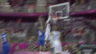

In [70]:
Amu, Alog_var = encoder2(images[118])
Aresult = decoder2(sample(Amu, Alog_var))
display_tensor_image(Aresult[0])

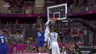

In [63]:
display_tensor_image(images[118])

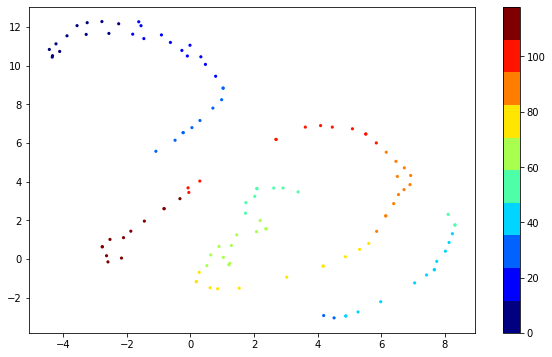

In [720]:
test_features = []
test_labels=[]
test_sigmas=[]
for i in range(len(images)):
    z, sigma = encoder2(images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_sigmas.append(sigma)
    test_labels.append(i)
    
test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

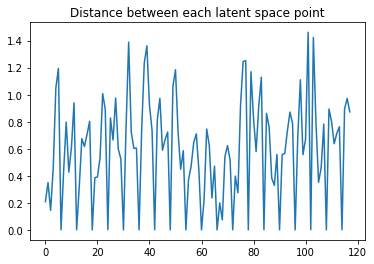

0.5953549017497808


In [721]:
plt.title("Distance between each latent space point")
plt.plot(get_latent_dist(test_features))
plt.show()
print(str(get_latent_dist(test_features).mean()))

Avg. latent space distance

In [722]:
# Test MSE of latent space
trained_mse = []
decoded_train_images = []
for i in range(len(images)):
    decoded_train_images.append(decoder2(sample(torch.from_numpy(test_features[i].astype(np.float32)), test_sigmas[i], testing=True)))
results = grade_results(images, decoded_train_images)
mean,variance = get_mean_variance(results)
print(str(mean + variance.max()) + " upper bound")

0: 0.00858745
1: 0.0058668917
2: 0.005214536
3: 0.0057330034
4: 0.008094904
5: 0.007511739
6: 0.0035720647
7: 0.0035682411
8: 0.003885072
9: 0.0066293366
10: 0.007941035
11: 0.007776949
12: 0.005893469
13: 0.0058971294
14: 0.007272273
15: 0.008432803
16: 0.008811449
17: 0.0072630346
18: 0.0051098703
19: 0.0051113525
20: 0.0067791557
21: 0.0075926664
22: 0.008175542
23: 0.0063069984
24: 0.004213518
25: 0.0042118034
26: 0.005425801
27: 0.007013961
28: 0.007874679
29: 0.0065550823
30: 0.0037367926
31: 0.0037397107
32: 0.0058860723
33: 0.011946549
34: 0.012477051
35: 0.009356897
36: 0.00596737
37: 0.0059702573
38: 0.0065427967
39: 0.006854973
40: 0.007891706
41: 0.007890844
42: 0.005093794
43: 0.0050969324
44: 0.006743744
45: 0.008165274
46: 0.008131487
47: 0.006946742
48: 0.006163579
49: 0.0061664563
50: 0.008401157
51: 0.012975571
52: 0.011510578
53: 0.009255772
54: 0.0046271835
55: 0.004625425
56: 0.007172414
57: 0.0086780535
58: 0.00827554
59: 0.0067747687
60: 0.0057777045
61: 0.005777

# Blocking out 10 frames in a row to attempt to recreate them

In [723]:
train_images = data[0]
train_images = train_images[:80] + train_images[90:]
test_images = train_images[80:90]
batch_size = 5
x_len = train_images[0].shape[0]
y_len = train_images[0].shape[1]
z_len = train_images[0].shape[2]
total_len = train_images[0].shape[0]*train_images[0].shape[1]*train_images[0].shape[2]
train_loader = DataLoader(train_images,batch_size=batch_size,drop_last = True,shuffle=True)

In [105]:

class Encoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
#     print(x)
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(-1, x_len, y_len, z_len)

In [106]:
encoder = Encoder(x_len,y_len,z_len,latent_dim)
decoder = Decoder(x_len,y_len,z_len,latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [107]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 40, x_len=x_len, y_len=y_len, z_len=z_len)

Epoch: 1 Batch: 1/21 Loss: 1152.80224609375
Epoch: 1 Batch: 11/21 Loss: 1702.3111328125
Epoch: 1 Batch: 21/21 Loss: 506.320654296875
Epoch: 1 avg loss: 1356.1997518276949
Epoch: 2 Batch: 1/21 Loss: 504.867041015625
Epoch: 2 Batch: 11/21 Loss: 433.2240234375
Epoch: 2 Batch: 21/21 Loss: 476.961572265625
Epoch: 2 avg loss: 434.432526474699
Epoch: 3 Batch: 1/21 Loss: 433.398974609375
Epoch: 3 Batch: 11/21 Loss: 455.487109375
Epoch: 3 Batch: 21/21 Loss: 356.9653564453125
Epoch: 3 avg loss: 375.69045432554475
Epoch: 4 Batch: 1/21 Loss: 364.8591064453125
Epoch: 4 Batch: 11/21 Loss: 345.7279296875
Epoch: 4 Batch: 21/21 Loss: 322.8613037109375
Epoch: 4 avg loss: 310.764739150301
Epoch: 5 Batch: 1/21 Loss: 313.990966796875
Epoch: 5 Batch: 11/21 Loss: 279.0169189453125
Epoch: 5 Batch: 21/21 Loss: 279.219921875
Epoch: 5 avg loss: 279.5140840022936
Epoch: 6 Batch: 1/21 Loss: 260.0083740234375
Epoch: 6 Batch: 11/21 Loss: 279.064306640625
Epoch: 6 Batch: 21/21 Loss: 277.23115234375
Epoch: 6 avg loss:

In [108]:
torch.save(encoder, "models/train_lebron1_encoder")
torch.save(decoder, "models/train_lebron1_decoder")

In [724]:
trained_encoder = torch.load("models/train_lebron1_encoder")
trained_encoder.eval()
trained_decoder = torch.load("models/train_lebron1_decoder")
trained_decoder.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

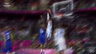

In [120]:
Amu, Alog_var = trained_encoder(train_images[100])
Aresult = trained_decoder(sample(Amu, Alog_var))
display_tensor_image(Aresult[0])

Missing frames 80->89...
Will use GP in latent space to recover these frames

In [121]:
from sklearn.manifold import TSNE

In [725]:
test_features = []
test_labels=[]
test_sigmas = []
for i in range(len(train_images)):
    z, sigma = trained_encoder(train_images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_sigmas.append(sigma)
    test_labels.append(i)
    
test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)


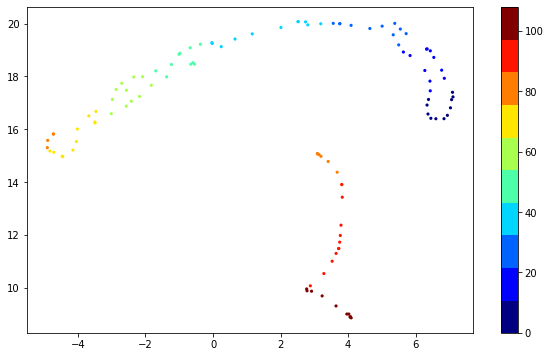

In [142]:
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

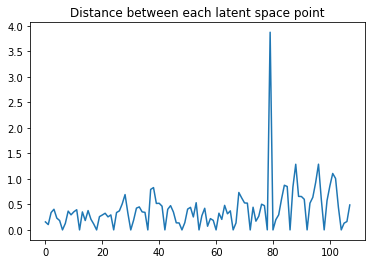

Avg latent space dist: 0.39734384160261405
Missing frames latent dist: : 3.876356363296509


In [727]:
plt.title("Distance between each latent space point")
plt.plot(get_latent_dist(test_features))
plt.show()
print("Avg latent space dist: " + str(get_latent_dist(test_features).mean()))
print("Missing frames latent dist: : " + str(get_latent_dist(test_features).max()))

In [694]:
# Test MSE of latent space
trained_mse = []
decoded_train_images = []
for i in range(len(train_images)):
    decoded_train_images.append(trained_decoder(sample(torch.from_numpy(test_features[i].astype(np.float32)), test_sigmas[i], testing=True)))
results = grade_results(train_images, decoded_train_images)
mean,variance = get_mean_variance(results)
print(str(mean + variance.max()) + " upper bound")

0: 0.014521268
1: 0.012718208
2: 0.01232038
3: 0.01173434
4: 0.010636539
5: 0.008204623
6: 0.0061403103
7: 0.0061341743
8: 0.0064333593
9: 0.008657239
10: 0.01028142
11: 0.010435781
12: 0.009913987
13: 0.009922938
14: 0.010996689
15: 0.010901237
16: 0.010018974
17: 0.009008276
18: 0.008539774
19: 0.008542053
20: 0.009651374
21: 0.010051397
22: 0.010185425
23: 0.010021306
24: 0.009332046
25: 0.009334649
26: 0.011106489
27: 0.013233643
28: 0.01572583
29: 0.015564395
30: 0.015237803
31: 0.015240228
32: 0.015237953
33: 0.012630225
34: 0.011916162
35: 0.012510994
36: 0.012211617
37: 0.012218045
38: 0.013012054
39: 0.017764445
40: 0.020369744
41: 0.020492313
42: 0.017814161
43: 0.017816555
44: 0.017114628
45: 0.016575426
46: 0.01589748
47: 0.013490434
48: 0.012651803
49: 0.012655406
50: 0.013387109
51: 0.0158969
52: 0.016648136
53: 0.01538929
54: 0.015040518
55: 0.015041203
56: 0.014339788
57: 0.015415608
58: 0.013829989
59: 0.013293594
60: 0.012451358
61: 0.012451816
62: 0.012457008
63: 0.0

In [150]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct, WhiteKernel, Sum
from sklearn.gaussian_process import GaussianProcessRegressor

In [735]:
x1 = list(np.linspace(0,79, 80).astype(int))
x2 = list(np.linspace(90,len(images)-1, len(images)-90).astype(int))
X = x1+x2
X = np.array(X).reshape(-1, 1)

In [737]:
kernel = RBF()*ConstantKernel()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4, random_state=0).fit(X, test_features)
gpr.score(X, test_features)

/Users/joshpapermaster/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9985726736028765

In [738]:
test_x = np.linspace(80,89, 10).astype(int).reshape(-1,1)

In [739]:
predictions, std = gpr.predict(test_x, return_std=True)
predictions = torch.from_numpy(predictions.astype(np.float32))
log_vars =torch.from_numpy(np.log(std**2))

In [740]:
recovered_images=[]
for i in range(len(test_x)):
    recovered_images.append(trained_decoder(sample(predictions[i], log_vars[i], testing=True)).squeeze())

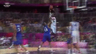

In [424]:
display_tensor_image(recovered_images[8])

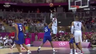

In [425]:
display_tensor_image(images[88])

In [276]:
import pandas as pd
df = pd.DataFrame(test_features)
df.to_csv("latent_space.csv")
df = pd.DataFrame(X)
df.to_csv("latent_space_x.csv")

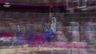

In [335]:
display_tensor_image(recovered_images[5])

In [741]:
test_pred = images[80:90]
grade_results(test_pred, recovered_images);

0: 0.021175826
1: 0.0254622
2: 0.027538272
3: 0.028232118
4: 0.026729897
5: 0.024459913
6: 0.023625668
7: 0.022397995
8: 0.019715369
9: 0.012858511
avg error: 0.023219576


In [742]:
print ("Avg posterior variance: " + str(np.exp(log_vars.numpy()).mean()))

Avg posterior variance: 0.07422453102143475


In [553]:
stan_preds = np.array(pd.read_csv("prediction80-89.csv").drop(['Unnamed: 0'], axis=1).T)
stan_preds = torch.from_numpy(stan_preds.astype(np.float32))

In [557]:
recovered_stan_images=[]
for i in range(len(test_x)):
    recovered_stan_images.append(trained_decoder(sample(stan_preds[i], torch.zeros(len(stan_preds[0])), testing=True)).squeeze())

In [559]:
test_pred = images[80:90]
grade_results(test_pred, recovered_stan_images);

0: 0.03485465
1: 0.035133354
2: 0.034477986
3: 0.034743965
4: 0.035283282
5: 0.034374427
6: 0.03427704
7: 0.033047695
8: 0.032524567
9: 0.0323027
avg error: 0.034101967


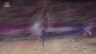

In [573]:
display_tensor_image(recovered_stan_images[4])

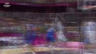

In [569]:
display_tensor_image(recovered_images[1])

In [372]:
black_img = torch.zeros(3, 54, 96);

In [388]:
temp_images = data[0]
temp_blanks = []
for i in range(10):
    temp_blanks.append(black_img)
temp_images = temp_images[:80] + temp_blanks + temp_images[90:]
create_img_folder(temp_images, "blacked_out_lebron1")
recreate_movie("blacked_out_lebron1", "recreated_movies/lost_frames_lebron_1")

In [390]:
# create_img_folder(temp_images, "blacked_out_lebron1")

In [391]:
# recreate_movie("blacked_out_lebron1", "recreated_movies/lost_frames_lebron_1")

t:  41%|████      | 49/119 [00:00<00:00, 489.81it/s, now=None]

Moviepy - Building video recreated_movies/lost_frames_lebron_1.mp4.
Moviepy - Writing video recreated_movies/lost_frames_lebron_1.mp4



Moviepy - Done !
Moviepy - video ready recreated_movies/lost_frames_lebron_1.mp4


In [438]:
temp_images = data[0]
temp_blanks = []
for i in range(10):
    temp_blanks.append(recovered_images[i])
temp_images = temp_images[:80] + temp_blanks + temp_images[90:]
create_img_folder(temp_images, "recovered_lebron1")
recreate_movie("recovered_lebron1", "recreated_movies/recovered_lebron1")

In [439]:
# create_img_folder(temp_images, "recovered_lebron1")

In [440]:
# recreate_movie("recovered_lebron1", "recreated_movies/recovered_lebron1")

Moviepy - Building video recreated_movies/recovered_lebron1.mp4.
Moviepy - Writing video recreated_movies/recovered_lebron1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/recovered_lebron1.mp4


# Blocking out 20 Frames in the middle

In [743]:
train_images = data[0]
train_images = train_images[:40] + train_images[60:]
test_images = train_images[40:60]
batch_size = 5
x_len = train_images[0].shape[0]
y_len = train_images[0].shape[1]
z_len = train_images[0].shape[2]
total_len = train_images[0].shape[0]*train_images[0].shape[1]*train_images[0].shape[2]
train_loader = DataLoader(train_images,batch_size=batch_size,drop_last = True,shuffle=True)

In [442]:

class Encoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Encoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(total_len, total_len*3//4)
    self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
    self.lin3a = nn.Linear(total_len*1//4, latent_dim)
    self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
  def forward(self, x):
    ## YOUR CODE HERE ##\
#     print(x)
    x = x.view(-1, total_len)
#     print(x)
    x = nn.functional.relu(self.lin1(x))
#     print(x)
    x = nn.functional.relu(self.lin2(x))
    # mu, log_var
    return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
  def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
    super(Decoder, self).__init__()
    ## YOUR CODE HERE ##
    total_len = x_len*y_len*z_len
    self.lin1 = nn.Linear(latent_dim, total_len*1//4)
    self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
    self.lin3 = nn.Linear(total_len*3//4, total_len)

  def forward(self,x):
    ## YOUR CODE HERE ##
    x = nn.functional.relu(self.lin1(x))
    x = nn.functional.relu(self.lin2(x))
    x = torch.sigmoid(self.lin3(x))
    return x.view(-1, x_len, y_len, z_len)

In [443]:
encoder = Encoder(x_len,y_len,z_len,latent_dim)
decoder = Decoder(x_len,y_len,z_len,latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [444]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 40, x_len=x_len, y_len=y_len, z_len=z_len)

Epoch: 1 Batch: 1/19 Loss: 1188.93759765625
Epoch: 1 Batch: 11/19 Loss: 1890.0361328125
Epoch: 1 avg loss: 1630.9926017992425
Epoch: 2 Batch: 1/19 Loss: 565.309228515625
Epoch: 2 Batch: 11/19 Loss: 445.423583984375
Epoch: 2 avg loss: 446.2530332623106
Epoch: 3 Batch: 1/19 Loss: 475.919384765625
Epoch: 3 Batch: 11/19 Loss: 392.1380126953125
Epoch: 3 avg loss: 365.9933823094224
Epoch: 4 Batch: 1/19 Loss: 350.945654296875
Epoch: 4 Batch: 11/19 Loss: 277.843408203125
Epoch: 4 avg loss: 326.16503782946654
Epoch: 5 Batch: 1/19 Loss: 329.3243896484375
Epoch: 5 Batch: 11/19 Loss: 373.0439208984375
Epoch: 5 avg loss: 321.72158227785667
Epoch: 6 Batch: 1/19 Loss: 308.732373046875
Epoch: 6 Batch: 11/19 Loss: 355.720849609375
Epoch: 6 avg loss: 299.61951176807133
Epoch: 7 Batch: 1/19 Loss: 300.2178955078125
Epoch: 7 Batch: 11/19 Loss: 269.40966796875
Epoch: 7 avg loss: 284.01819340869633
Epoch: 8 Batch: 1/19 Loss: 300.042724609375
Epoch: 8 Batch: 11/19 Loss: 253.745068359375
Epoch: 8 avg loss: 272

In [445]:
torch.save(encoder, "models/train_lebron2_encoder")
torch.save(decoder, "models/train_lebron2_decoder")

In [744]:
trained_encoder = torch.load("models/train_lebron1_encoder")
trained_encoder.eval()
trained_decoder = torch.load("models/train_lebron1_decoder")
trained_decoder.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

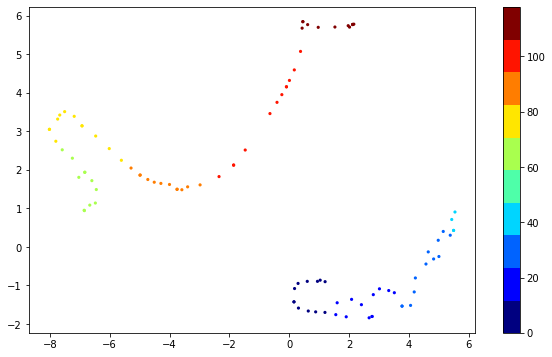

In [745]:
test_features = []
test_labels=[]
test_sigmas=[]
for i in range(len(train_images)):
    z, sigma = trained_encoder(train_images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_sigmas.append(sigma)
    
x1 = list(np.linspace(0,39, 40).astype(int))
x2 = list(np.linspace(60,len(images)-1, len(images)-60).astype(int))
test_labels = x1+x2

test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

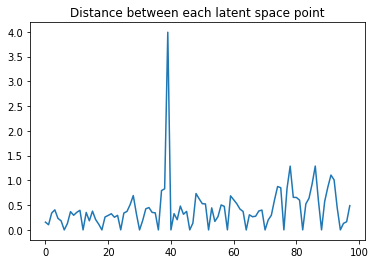

Avg latent space dist: 0.42134417975362987
Missing frames latent dist: : 3.9903147220611572


In [746]:
plt.title("Distance between each latent space point")
plt.plot(get_latent_dist(test_features))
plt.show()
print("Avg latent space dist: " + str(get_latent_dist(test_features).mean()))
print("Missing frames latent dist: : " + str(get_latent_dist(test_features).max()))

In [698]:
# Test MSE of latent space
trained_mse = []
decoded_train_images = []
for i in range(len(train_images)):
    decoded_train_images.append(trained_decoder(sample(torch.from_numpy(test_features[i].astype(np.float32)), test_sigmas[i], testing=True)))
results = grade_results(train_images, decoded_train_images)
mean,variance = get_mean_variance(results)
print(str(mean + variance.max()) + " upper bound")

0: 0.014521268
1: 0.012718208
2: 0.01232038
3: 0.01173434
4: 0.010636539
5: 0.008204623
6: 0.0061403103
7: 0.0061341743
8: 0.0064333593
9: 0.008657239
10: 0.01028142
11: 0.010435781
12: 0.009913987
13: 0.009922938
14: 0.010996689
15: 0.010901237
16: 0.010018974
17: 0.009008276
18: 0.008539774
19: 0.008542053
20: 0.009651374
21: 0.010051397
22: 0.010185425
23: 0.010021306
24: 0.009332046
25: 0.009334649
26: 0.011106489
27: 0.013233643
28: 0.01572583
29: 0.015564395
30: 0.015237803
31: 0.015240228
32: 0.015237953
33: 0.012630225
34: 0.011916162
35: 0.012510994
36: 0.012211617
37: 0.012218045
38: 0.013012054
39: 0.017764445
40: 0.012451358
41: 0.012451816
42: 0.012457008
43: 0.011092776
44: 0.012599553
45: 0.013902933
46: 0.015579851
47: 0.0155760525
48: 0.015226526
49: 0.01781502
50: 0.017354691
51: 0.01376791
52: 0.009473418
53: 0.009473823
54: 0.008826303
55: 0.010040124
56: 0.011331594
57: 0.01258888
58: 0.014610146
59: 0.014608795
60: 0.020682665
61: 0.024143174
62: 0.025300158
63: 0

In [747]:
x1 = list(np.linspace(0,39, 40).astype(int))
x2 = list(np.linspace(60,len(images)-1, len(images)-60).astype(int))
X = x1+x2
X = np.array(X).reshape(-1, 1)
kernel = RBF()*ConstantKernel()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4, random_state=0).fit(X, test_features)
gpr.score(X, test_features)

/Users/joshpapermaster/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9986969208284076

In [750]:
test_x = np.linspace(40,60, 20).astype(int).reshape(-1,1)
predictions, std = gpr.predict(test_x, return_std=True)
predictions = torch.from_numpy(predictions.astype(np.float32))
log_vars = torch.from_numpy(np.log(std**2))

In [462]:
recovered_images=[]
for i in range(len(test_x)):
    recovered_images.append(trained_decoder(sample(predictions[i], log_vars[i], testing=True)).squeeze())

In [457]:
df = pd.DataFrame(test_features)
df.to_csv("latent_space20.csv")
df = pd.DataFrame(X)
df.to_csv("latent_space_x20.csv")

In [463]:
test_pred = images[40:60]
grade_results(test_pred, recovered_images);

0: 0.023064964
1: 0.021879992
2: 0.01867803
3: 0.01853227
4: 0.015547087
5: 0.012841156
6: 0.011673181
7: 0.012755939
8: 0.016852
9: 0.020093894
10: 0.022461683
11: 0.023158396
12: 0.022040835
13: 0.020463929
14: 0.020270374
15: 0.019941919
16: 0.018981557
17: 0.018086514
18: 0.016309187
19: 0.0140192425
avg error: 0.018382609


In [751]:
print ("Avg posterior variance: " + str(np.exp(log_vars.numpy()).mean()))

Avg posterior variance: 0.2592506568452754


In [472]:
temp_images = data[0]
temp_blanks = []
for i in range(10):
    temp_blanks.append(black_img)
temp_images = temp_images[:40] + temp_blanks + temp_images[60:]
create_img_folder(temp_images, "20_blacked_out_lebron1")
recreate_movie("20_blacked_out_lebron1", "recreated_movies/20_lost_frames_lebron_1")

Moviepy - Building video recreated_movies/20_lost_frames_lebron_1.mp4.
Moviepy - Writing video recreated_movies/20_lost_frames_lebron_1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/20_lost_frames_lebron_1.mp4


In [492]:
temp_images = data[0]
temp_blanks = []
for i in range(20):
    temp_blanks.append(recovered_images[i])
temp_images = temp_images[:40] + temp_blanks + temp_images[60:]
create_img_folder(temp_images, "recovered_20_lebron1")
recreate_movie("recovered_20_lebron1", "recreated_movies/recovered_20_lebron1")

Moviepy - Building video recreated_movies/recovered_20_lebron1.mp4.
Moviepy - Writing video recreated_movies/recovered_20_lebron1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/recovered_20_lebron1.mp4


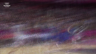

In [474]:
display_tensor_image(recovered_images[6])

# Scattered Missing Frames

In [752]:
train_images = []
test_x = []
test_images = []
train_x = []
total_x = []
for i in range(len(data[0])):
    if i%5==0 and i!=0:
        test_images.append(data[0][i])
        test_x.append(i)
        total_x.append(black_img)
    else:
        train_images.append(data[0][i])
        train_x.append(i)
        total_x.append(data[0][i])
batch_size = 5
x_len = train_images[0].shape[0]
y_len = train_images[0].shape[1]
z_len = train_images[0].shape[2]
total_len = train_images[0].shape[0]*train_images[0].shape[1]*train_images[0].shape[2]
train_loader = DataLoader(train_images,batch_size=batch_size,drop_last = True,shuffle=True)

In [581]:

class Encoder(nn.Module):
    def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
        super(Encoder, self).__init__()
        ## YOUR CODE HERE ##
        total_len = x_len*y_len*z_len
        self.lin1 = nn.Linear(total_len, total_len*3//4)
        self.lin2 = nn.Linear(total_len*3//4, total_len*1//4)
        self.lin3a = nn.Linear(total_len*1//4, latent_dim)
        self.lin3b = nn.Linear(total_len*1//4, latent_dim)
  
    def forward(self, x):
        ## YOUR CODE HERE ##\
    #     print(x)
        x = x.view(-1, total_len)
    #     print(x)
        x = nn.functional.relu(self.lin1(x))
    #     print(x)
        x = nn.functional.relu(self.lin2(x))
        # mu, log_var
        return self.lin3a(x), self.lin3b(x)

class Decoder(nn.Module):
    def __init__(self, x_len=x_len, y_len=y_len, z_len=z_len, latent_dim=latent_dim):
        super(Decoder, self).__init__()
        ## YOUR CODE HERE ##
        total_len = x_len*y_len*z_len
        self.lin1 = nn.Linear(latent_dim, total_len*1//4)
        self.lin2 = nn.Linear(total_len*1//4, total_len*3//4)
        self.lin3 = nn.Linear(total_len*3//4, total_len)

    def forward(self,x):
        ## YOUR CODE HERE ##
        x = nn.functional.relu(self.lin1(x))
        x = nn.functional.relu(self.lin2(x))
        x = torch.sigmoid(self.lin3(x))
        return x.view(-1, x_len, y_len, z_len)

In [582]:
encoder = Encoder(x_len,y_len,z_len,latent_dim)
decoder = Decoder(x_len,y_len,z_len,latent_dim)
params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(params, lr=1e-3)

In [583]:
train(encoder, decoder, train_loader, optimizer, num_epochs = 65, x_len=x_len, y_len=y_len, z_len=z_len)

Epoch: 1 Batch: 1/19 Loss: 1161.5484375
Epoch: 1 Batch: 11/19 Loss: 1532.36005859375
Epoch: 1 avg loss: 1522.1639302571614
Epoch: 2 Batch: 1/19 Loss: 1306.7123046875
Epoch: 2 Batch: 11/19 Loss: 564.89287109375
Epoch: 2 avg loss: 596.2792689005533
Epoch: 3 Batch: 1/19 Loss: 457.124658203125
Epoch: 3 Batch: 11/19 Loss: 435.61181640625
Epoch: 3 avg loss: 418.2473538716634
Epoch: 4 Batch: 1/19 Loss: 388.7469482421875
Epoch: 4 Batch: 11/19 Loss: 389.791552734375
Epoch: 4 avg loss: 371.7119140625
Epoch: 5 Batch: 1/19 Loss: 318.144189453125
Epoch: 5 Batch: 11/19 Loss: 339.8393798828125
Epoch: 5 avg loss: 326.4059232076009
Epoch: 6 Batch: 1/19 Loss: 302.7243408203125
Epoch: 6 Batch: 11/19 Loss: 339.63974609375
Epoch: 6 avg loss: 306.48866017659503
Epoch: 7 Batch: 1/19 Loss: 299.63544921875
Epoch: 7 Batch: 11/19 Loss: 306.2961669921875
Epoch: 7 avg loss: 295.67143122355145
Epoch: 8 Batch: 1/19 Loss: 327.2535888671875
Epoch: 8 Batch: 11/19 Loss: 309.3496337890625
Epoch: 8 avg loss: 283.572889963

In [584]:
torch.save(encoder, "models/scattered_lebron_encoder")
torch.save(decoder, "models/scattered_lebron_decoder")

In [753]:
trained_encoder = torch.load("models/scattered_lebron_encoder")
trained_encoder.eval()
trained_decoder = torch.load("models/scattered_lebron_decoder")
trained_decoder.eval()

Decoder(
  (lin1): Linear(in_features=20, out_features=3888, bias=True)
  (lin2): Linear(in_features=3888, out_features=11664, bias=True)
  (lin3): Linear(in_features=11664, out_features=15552, bias=True)
)

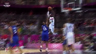

In [678]:
Amu, Alog_var = trained_encoder(train_images[80])
Aresult = trained_decoder(sample(Amu, Alog_var, testing=True))
display_tensor_image(Aresult[0])

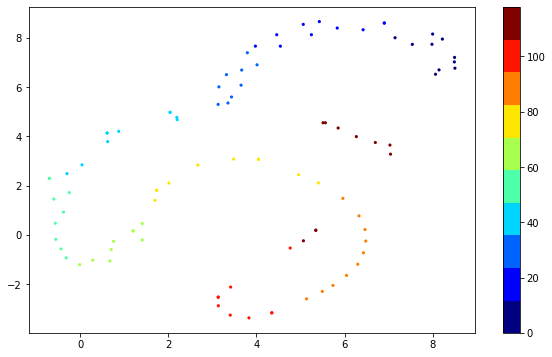

In [757]:
test_features = []
test_sigs = []
test_labels=[]
for i in range(len(train_images)):
    z, sigma = trained_encoder(train_images[i])
    z = z.detach().numpy()
    z = np.squeeze(z)
    test_features.append(z)
    test_sigs.append(sigma)
    
test_labels = train_x

test_features = np.array(test_features)
test_labels = np.array(test_labels)

#reduce dimensionality to 2D, we consider a subset of data because TSNE
tsne_features = TSNE(n_components=2).fit_transform(test_features)
fig = plt.figure(figsize=(10, 6))

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=test_labels[:tsne_features.shape[0]], marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
plt.grid(False)
plt.axis('on')
plt.colorbar()

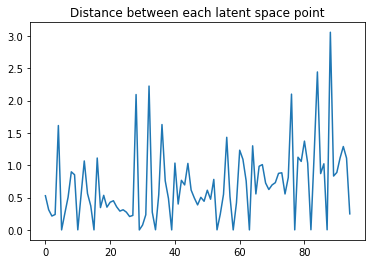

Avg latent space dist: 0.6968104788500472
Max latent dist: : 3.0581839084625244


In [764]:
plt.title("Distance between each latent space point")
plt.plot(get_latent_dist(test_features))
plt.show()
print("Avg latent space dist: " + str(get_latent_dist(test_features).mean()))
print("Max latent dist: : " + str(get_latent_dist(test_features).max()))

In [681]:
# Test MSE of latent space
trained_mse = []
decoded_train_images = []
for i in range(len(train_images)):
    decoded_train_images.append(trained_decoder(sample(torch.from_numpy(test_features[i].astype(np.float32)), test_sigs[i], testing=True)))
results = grade_results(train_images, decoded_train_images)
mean,variance = get_mean_variance(results)
print(str(mean + variance.max()) + " upper bound")

0: 0.0093252305
1: 0.007152417
2: 0.0071967766
3: 0.0071430006
4: 0.009084895
5: 0.0039853775
6: 0.003981346
7: 0.003426079
8: 0.007718606
9: 0.011640175
10: 0.009327959
11: 0.009327991
12: 0.009336246
13: 0.00867147
14: 0.007167002
15: 0.0056160614
16: 0.005620262
17: 0.008947016
18: 0.008731734
19: 0.008274603
20: 0.009700805
21: 0.011037592
22: 0.01154639
23: 0.011879186
24: 0.011924242
25: 0.011498983
26: 0.011643525
27: 0.012569484
28: 0.015739547
29: 0.0039537866
30: 0.0039573535
31: 0.0073430357
32: 0.011855014
33: 0.008909678
34: 0.0028667895
35: 0.002859474
36: 0.008056593
37: 0.011586297
38: 0.009137973
39: 0.0049210642
40: 0.0049226102
41: 0.008573873
42: 0.00506531
43: 0.0057054786
44: 0.008278845
45: 0.008570887
46: 0.008940985
47: 0.009186016
48: 0.009460116
49: 0.008818367
50: 0.007794787
51: 0.0088712
52: 0.010063924
53: 0.0043562646
54: 0.0043630116
55: 0.0058298446
56: 0.007935587
57: 0.009571684
58: 0.005141797
59: 0.005140458
60: 0.0069985995
61: 0.0063867345
62: 0.

In [688]:
mean,variance = get_mean_variance(results)
mean + variance.max()

0.007068748040442028

In [606]:
df = pd.DataFrame(test_features)
df.to_csv("latent_space_scattered_y.csv")
df = pd.DataFrame(train_x)
df.to_csv("latent_space_scattered_x.csv")
df = pd.DataFrame(test_x)
df.to_csv("latent_space_scattered_pred_x.csv")

In [599]:
X = np.array(train_x).reshape(-1, 1)
kernel = RBF()*ConstantKernel()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=4, random_state=0).fit(X, test_features)
gpr.score(X, test_features)

/Users/joshpapermaster/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9950824811463671

In [601]:
X_test = np.array(test_x).reshape(-1,1)
predictions, std = gpr.predict(X_test, return_std=True)
predictions = torch.from_numpy(predictions.astype(np.float32))
log_vars = torch.from_numpy(np.log(std**2))

recovered_images=[]
for i in range(len(X_test)):
    recovered_images.append(trained_decoder(sample(predictions[i], log_vars[i], testing=True)).squeeze())

In [602]:
grade_results(test_images, recovered_images);

0: 0.010010283
1: 0.0116272075
2: 0.010114334
3: 0.008902749
4: 0.0088462215
5: 0.013687951
6: 0.013892336
7: 0.012410878
8: 0.0156807
9: 0.011023336
10: 0.007748647
11: 0.008657884
12: 0.009565843
13: 0.014472833
14: 0.010980681
15: 0.009911918
16: 0.005664369
17: 0.006987347
18: 0.009213635
19: 0.012586427
20: 0.01103397
21: 0.013853019
22: 0.00441135
avg error: 0.010490606


In [705]:
print ("Avg posterior variance: " + str(np.exp(log_vars.numpy()).mean()))

Avg posterior variance: 0.008325881026316817


In [604]:
create_img_folder(total_x, "scattered_blacked_out_lebron1")
recreate_movie("scattered_blacked_out_lebron1", "recreated_movies/scattered_blacked_out_lebron1")

t:   0%|          | 0/119 [00:00<?, ?it/s, now=None]

Moviepy - Building video recreated_movies/scattered_blacked_out_lebron1.mp4.
Moviepy - Writing video recreated_movies/scattered_blacked_out_lebron1.mp4



Moviepy - Done !
Moviepy - video ready recreated_movies/scattered_blacked_out_lebron1.mp4


In [620]:
temp_images = data[0]
temp_results = []
r=0
for i in range(len(total_x)):
    if (i%5==0 and i!=0):
        temp_results.append(recovered_images[r])
        r+=1
    else:
        temp_results.append(total_x[i])
create_img_folder(temp_results, "recovered_scattered_lebron1")
recreate_movie("recovered_scattered_lebron1", "recreated_movies/recovered_scattered_lebron1")

Moviepy - Building video recreated_movies/recovered_scattered_lebron1.mp4.
Moviepy - Writing video recreated_movies/recovered_scattered_lebron1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/recovered_scattered_lebron1.mp4


In [636]:
standard_vae_x = copy(total_x)

In [759]:
j=1
standard_recovered=[]
for i in range(5,len(standard_vae_x),5):
    temp = test_features[i-j] + test_features[i-j+1]
    temp /= 2
    temp = torch.from_numpy(temp.astype(np.float32))
    standard_recovered.append(trained_decoder(temp).squeeze())
    standard_vae_x[i] = trained_decoder(temp).squeeze()
    j+=1

In [760]:
results = grade_results(test_images, standard_recovered);

0: 0.009623822
1: 0.01138548
2: 0.010300301
3: 0.00920091
4: 0.009159508
5: 0.012621178
6: 0.013316086
7: 0.0119523965
8: 0.013310293
9: 0.010801323
10: 0.0076897596
11: 0.008704123
12: 0.0095367
13: 0.01402087
14: 0.010335571
15: 0.009134312
16: 0.0059385435
17: 0.0067053526
18: 0.008559444
19: 0.012667761
20: 0.011330297
21: 0.011772575
22: 0.004308963
avg error: 0.010103286


In [763]:
mean,variance = get_mean_variance(results)
print("Variance: " + str(mean + variance.max()))

Variance: 0.010136860423576963


In [638]:
create_img_folder(standard_vae_x, "standard_scattered_lebron1")
recreate_movie("standard_scattered_lebron1", "recreated_movies/standard_scattered_lebron1")

Moviepy - Building video recreated_movies/standard_scattered_lebron1.mp4.
Moviepy - Writing video recreated_movies/standard_scattered_lebron1.mp4

Moviepy - Done !
Moviepy - video ready recreated_movies/standard_scattered_lebron1.mp4


In [645]:
stan_preds = pd.read_csv("prediction_2.csv")

In [648]:
stan_preds = np.array(stan_preds.T)

In [649]:
X_test = np.array(test_x).reshape(-1,1)
predictions = torch.from_numpy(stan_preds.astype(np.float32))
log_vars =torch.from_numpy(np.log(std**2))

stan_recovered_images=[]
for i in range(len(X_test)):
    stan_recovered_images.append(trained_decoder(sample(predictions[i], log_vars[i], testing=True)).squeeze())

In [650]:
grade_results(test_images, stan_recovered_images);

0: 0.05494583
1: 0.040166896
2: 0.040520623
3: 0.043126386
4: 0.03968046
5: 0.022683077
6: 0.015389903
7: 0.02289606
8: 0.032020926
9: 0.035230685
10: 0.03121022
11: 0.029083185
12: 0.024211532
13: 0.03102974
14: 0.030894734
15: 0.03237866
16: 0.033531055
17: 0.041142408
18: 0.043065555
19: 0.04504876
20: 0.04718068
21: 0.050249886
22: 0.05398563
avg error: 0.036507517


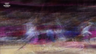

In [658]:
display_tensor_image(stan_recovered_images[18])

In [702]:
std**2

array([0.00847777, 0.00832615, 0.00829677, 0.00828938, 0.00828738,
       0.00828683, 0.00828667, 0.00828663, 0.00828662, 0.00828661,
       0.00828661, 0.00828661, 0.00828661, 0.00828661, 0.00828662,
       0.00828666, 0.00828677, 0.00828716, 0.00828854, 0.00829349,
       0.00831191, 0.00838798, 0.00880887])